In [1]:
import csv
import sys
import os

import numpy as np
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

MIN_TRANSFORMERS_VERSION = "4.25.1"

# check transformers version
assert (
    transformers.__version__ >= MIN_TRANSFORMERS_VERSION
), f"Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher."

root_dir = "/Users/kenzaamara/GithubProjects/syntax-shap/shap2"
sys.path.append(root_dir)

/cluster/home/kamara/.local/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [13]:
import pandas as pd
import os
import re

def parse_filename(filename):
    """Parse the filename to extract algorithm, dataset, and model."""
    pattern = r"_algorithm=(.*?)_dataset=(.*?)_model_name=(.*?)\.stdout"
    match = re.search(pattern, filename)
    if match:
        return match.groups()
    else:
        return None, None, None
    
def tail(filename, n=1):
    """Read the last n lines from a file."""
    with open(filename, 'rb') as f:
        f.seek(0, os.SEEK_END)
        end_byte = f.tell()
        lines_found = []
        while len(lines_found) < n and f.tell() > 0:
            f.seek(-2, os.SEEK_CUR)
            if f.read(1) == b'\n':
                lines_found.append(f.tell())
        f.seek(0)
        if lines_found:
            f.seek(lines_found[-1])
        else:
            f.seek(0)
        last_lines = f.read(end_byte - f.tell()).decode('utf-8').splitlines()
        return last_lines[-n:]


def get_last_values(filename):
    """Retrieve the last two values from the last two lines of a file."""
    try:
        last_lines = tail(filename, n=4)
        time_lines = last_lines[:2]
        if last_lines[-2].startswith("Done!"):
            last_values = [eval(line.split()[-1]) for line in time_lines]
            return last_values
        else:
            return [None, None]
    except IOError:
        print(f"Error reading file: {filename}")
        return [None, None]

def process_folder(folder_path):
    """Process all .out files in the specified folder."""
    data = []
    for file in os.listdir(folder_path):
        if file.endswith(".stdout"):
            file_path = os.path.join(folder_path, file)
            last_values = get_last_values(file_path)
            algorithm, dataset, model = parse_filename(file)
            # Add the extracted details as new columns
            data.append({
                "algorithm": algorithm,
                "dataset": dataset,
                "model": model,
                "time": last_values[0],
                "avg_time": last_values[1]
            })
    df = pd.DataFrame(data)
    return df

# Specify the folder path here
folder_path = "/cluster/work/zhang/kamara/syntax-shap/checkpoints/computation_time/logs"
df = process_folder(folder_path)

# Print the DataFrame
df.groupby(["model", "dataset", "algorithm"]).mean()


['Computation time for 300 samples: 5422.908971071243', 'Average computation time per sample: 18.076363236904143', 'Done!', 'JOB_FINISHED']
['Computation time for 300 samples: 71.84558343887329', 'Average computation time per sample: 0.23948527812957765', 'Done!', 'JOB_FINISHED']
['Computation time for 300 samples: 12488.882844686508', 'Average computation time per sample: 41.62960948228836', 'Done!', 'JOB_FINISHED']
['Computation time for 300 samples: 265.1213402748108', 'Average computation time per sample: 0.8837378009160359', 'Done!', 'JOB_FINISHED']
['Computation time for 300 samples: 117.54591608047485', 'Average computation time per sample: 0.3918197202682495', 'Done!', 'JOB_FINISHED']
['Computation time for 300 samples: 737.6794593334198', 'Average computation time per sample: 2.4589315311113995', 'Done!', 'JOB_FINISHED']
['Computation time for 300 samples: 88.78828358650208', 'Average computation time per sample: 0.29596094528834027', 'Done!', 'JOB_FINISHED']
['Computation tim

time   avg_time
model   dataset    algorithm                         
gpt2    generics   lime          88.788284   0.295961
                   partition     95.512155   0.318374
                   shap                NaN        NaN
                   syntax       923.731398   3.079105
                   syntax-w     999.247432   3.330825
        negation   lime          71.845583   0.239485
                   partition     41.826213   0.139421
                   shap         269.728739   0.899096
                   syntax       255.456724   0.851522
                   syntax-w     265.121340   0.883738
        rocstories lime          83.794274   0.279314
                   partition    117.545916   0.391820
                   shap                NaN        NaN
                   syntax      1352.487505   4.508292
                   syntax-w     930.307226   3.101024
mistral generics   lime          85.481025   0.284937
                   partition   1626.493086   5.421644
                   shap                NaN        NaN
                   syntax     10815.165498  36.050552
                   syntax-w   10838.397359  36.127991
        negation   lime          72.486431   0.241621
                   partition    737.679459   2.458932
                   shap        5422.908971  18.076363
                   syntax      1509.410031   5.031367
                   syntax-w    1514.885607   5.049619
        rocstories lime          81.662628   0.272209
                   partition   2159.677744   7.198926
                   shap                NaN        NaN
                   syntax     12498.010931  41.660036
                   syntax-w   12488.882845  41.629609

In [1]:
import os
import pandas as pd
import pickle
import numpy as np

folder_path = "/cluster/work/zhang/kamara/syntax-shap/results/scores/gpt2/negation"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')) and parts[1]!= "batch":
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[1]
            model_name = parts[2]
            algorithm = parts[3]
            seed = parts[4]
            threshold = parts[5].split('.pkl')[0]  # Removes the file extension

            # Construct the full file path
            file_path = os.path.join(folder_path, file)

            # Read the pickle file
            with open(full_path, 'rb') as file:
                data = pickle.load(file)

            # Assuming the content is a dictionary, create a DataFrame
            data['log_odds_keep_mean'] = np.mean(data['log_odds_keep'])
            data['fid_keep_rd_mean'] = np.mean(data['fid_keep_rd'])
            data['fid_keep_mean'] = np.mean(data['fid_keep'])
            data['fid_rmv_mean'] = np.mean(data['fid_rmv'])
            data['prob_diff_at_k'] = np.mean(data['prob_diff_at_k'])
            data['acc_at_k'] = np.mean(np.abs(data['acc_at_k']))
            df = pd.DataFrame([data])

            # Add the extracted details as new columns
            df['dataset'] = dataset
            df['model'] = model_name
            df['algorithm'] = algorithm
            df['threshold'] = eval(threshold)

            # Append to the list of dataframes
            df_list.append(df)

# Concatenate all dataframes in the list
df_negation_gpt2 = pd.concat(df_list, ignore_index=True)

col = ['dataset', 'model', 'algorithm', 'threshold', 'log_odds_keep_mean', 'fid_keep_mean', 'fid_rmv_mean', 'fid_keep_rd_mean', 'prob_diff_at_k', 'acc_at_k']
final_df = df_negation_gpt2[col]
final_df


,dataset,model,algorithm,threshold,log_odds_keep_mean,fid_keep_mean,fid_rmv_mean,fid_keep_rd_mean,prob_diff_at_k,acc_at_k
0,negation,gpt2,partition,0.7,-4.031256,0.099827,0.140803,0.106804,0.355458,0.378689
1,negation,gpt2,partition,0.5,-5.177346,0.122230,0.124561,0.128910,0.456830,0.280055
2,negation,gpt2,partition,0.3,-7.156950,0.153703,0.081746,0.155502,0.615468,0.168306
3,negation,gpt2,partition,0.6,-5.108528,0.117913,0.128987,0.126013,0.434597,0.295628
4,negation,gpt2,partition,0.1,-8.123047,0.164604,0.000000,0.169900,0.676896,0.140984
5,negation,gpt2,partition,0.4,-6.215461,0.142471,0.106237,0.144290,0.561649,0.201093
6,negation,gpt2,partition,0.2,-7.810296,0.160595,0.047791,0.165648,0.662077,0.142077
7,negation,gpt2,partition,0.8,-2.643088,0.074979,0.155733,0.083192,0.245676,0.496995
8,negation,gpt2,partition,0.9,-2.279902,0.068232,0.157659,0.069119,0.210526,0.541530
9,negation,gpt2,syntax-w,0.1,-8.123047,0.164604,0.000000,0.171125,0.676896,0.140984


In [2]:
col = ['dataset', 'model', 'algorithm', 'threshold', 'log_odds_keep_mean', 'fid_keep_mean', 'fid_rmv_mean', 'fid_keep_rd_mean', 'prob_diff_at_k', 'acc_at_k']
final_df = df_negation_gpt2[col]
final_df

,dataset,model,algorithm,threshold,log_odds_keep_mean,fid_keep_mean,fid_rmv_mean,fid_keep_rd_mean,prob_diff_at_k,acc_at_k
0,negation,gpt2,partition,0.7,-4.031256,0.099827,0.140803,0.106804,0.355458,0.378689
1,negation,gpt2,partition,0.5,-5.177346,0.122230,0.124561,0.128910,0.456830,0.280055
2,negation,gpt2,partition,0.3,-7.156950,0.153703,0.081746,0.155502,0.615468,0.168306
3,negation,gpt2,partition,0.6,-5.108528,0.117913,0.128987,0.126013,0.434597,0.295628
4,negation,gpt2,partition,0.1,-8.123047,0.164604,0.000000,0.169900,0.676896,0.140984
5,negation,gpt2,partition,0.4,-6.215461,0.142471,0.106237,0.144290,0.561649,0.201093
6,negation,gpt2,partition,0.2,-7.810296,0.160595,0.047791,0.165648,0.662077,0.142077
7,negation,gpt2,partition,0.8,-2.643088,0.074979,0.155733,0.083192,0.245676,0.496995
8,negation,gpt2,partition,0.9,-2.279902,0.068232,0.157659,0.069119,0.210526,0.541530
9,negation,gpt2,syntax-w,0.1,-8.123047,0.164604,0.000000,0.171125,0.676896,0.140984


## GPT2 Model

In [13]:
import os
import pandas as pd
import pickle
import numpy as np

folder_path = "/cluster/work/zhang/kamara/syntax-shap/results/scores/gpt2"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')) and parts[1]!= "batch":
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[1]
            model_name = parts[2]
            algorithm = parts[3]
            seed = parts[4]
            threshold = parts[5].split('.pkl')[0]  # Removes the file extension

            n_min, n_max = 0, None

            # Construct the full file path
            file_path = os.path.join(folder_path, file)

            # Read the pickle file
            with open(full_path, 'rb') as file:
                data = pickle.load(file)

            # Assuming the content is a dictionary, create a DataFrame
            data['log_odds_keep_mean'] = np.mean(data['log_odds_keep'][n_min:n_max])
            data['fid_keep_rd_mean'] = np.mean(data['fid_keep_rd'][n_min:n_max])
            data['fid_keep_mean'] = np.mean(data['fid_keep'][n_min:n_max])
            data['fid_rmv_mean'] = np.mean(data['fid_rmv'][n_min:n_max])
            data['prob_diff_at_k'] = np.mean(data['prob_diff_at_k'][n_min:n_max])
            data['acc_at_k'] = np.mean(np.abs(data['acc_at_k'])[n_min:n_max])
            df = pd.DataFrame([data])

            # Add the extracted details as new columns
            df['dataset'] = dataset
            df['model'] = model_name
            df['algorithm'] = algorithm
            df['threshold'] = eval(threshold)

            # Append to the list of dataframes
            df_list.append(df)

# Concatenate all dataframes in the list
df = pd.concat(df_list, ignore_index=True)

col = ['dataset', 'model', 'algorithm', 'threshold', 'log_odds_keep_mean', 'fid_keep_mean', 'fid_rmv_mean', 'fid_keep_rd_mean', 'prob_diff_at_k', 'acc_at_k']
final_df = df[col]
final_df


,dataset,model,algorithm,threshold,log_odds_keep_mean,fid_keep_mean,fid_rmv_mean,fid_keep_rd_mean,prob_diff_at_k,acc_at_k
0,negation,gpt2,partition,0.7,-4.031256,0.099827,0.140803,0.106804,0.355458,0.378689
1,negation,gpt2,partition,0.5,-5.177346,0.122230,0.124561,0.128910,0.456830,0.280055
2,negation,gpt2,partition,0.3,-7.156950,0.153703,0.081746,0.155502,0.615468,0.168306
3,negation,gpt2,partition,0.6,-5.108528,0.117913,0.128987,0.126013,0.434597,0.295628
4,negation,gpt2,partition,0.1,-8.123047,0.164604,0.000000,0.169900,0.676896,0.140984
...,...,...,...,...,...,...,...,...,...,...
130,generics,gpt2,syntax,0.8,-2.742690,0.089608,0.208681,0.099613,0.262408,0.502859
131,generics,gpt2,syntax,0.9,-1.663806,0.054488,0.212237,0.061371,0.160926,0.623780
132,generics,gpt2,syntax,0.7,-3.965353,0.123701,0.204344,0.135669,0.370631,0.389679
133,generics,gpt2,syntax,0.1,-9.179666,0.212222,0.036023,0.213991,0.691168,0.105370


/tmp/ipykernel_1157/1222072624.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


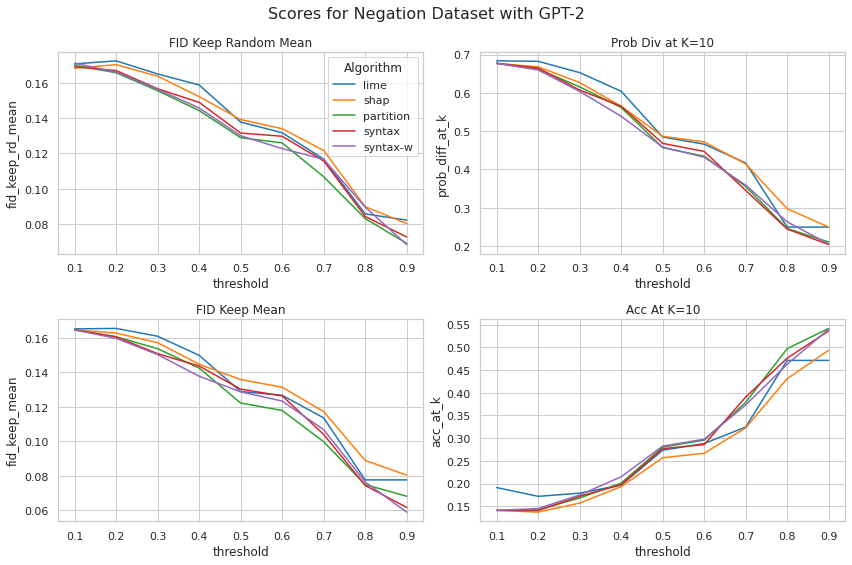

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = final_df[(final_df['dataset'] == 'negation')&(final_df['model'] == 'gpt2')]
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd_mean', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep_mean', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Negation Dataset with GPT-2', fontsize=16)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1157/2077221429.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


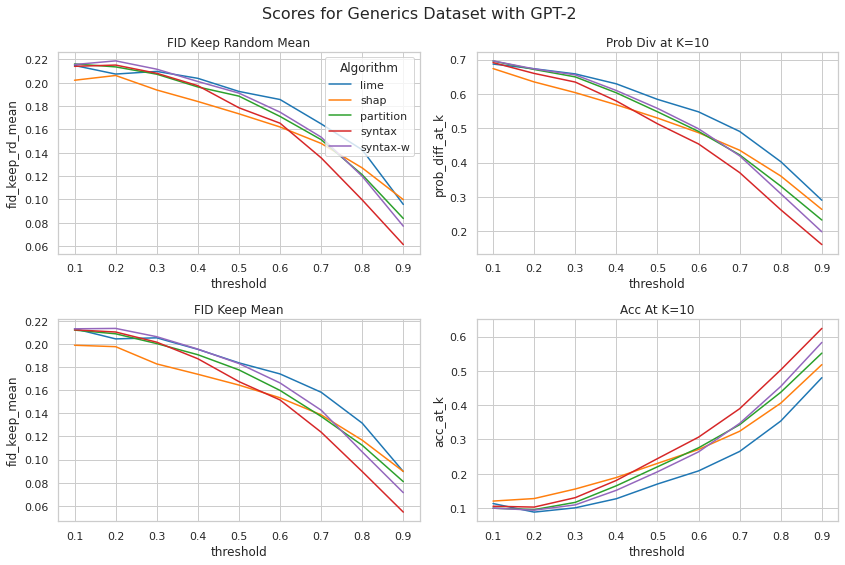

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = final_df[(final_df['dataset'] == 'generics')&(final_df['model'] == 'gpt2')]
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd_mean', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep_mean', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Generics Dataset with GPT-2', fontsize=16)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1157/3424311528.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


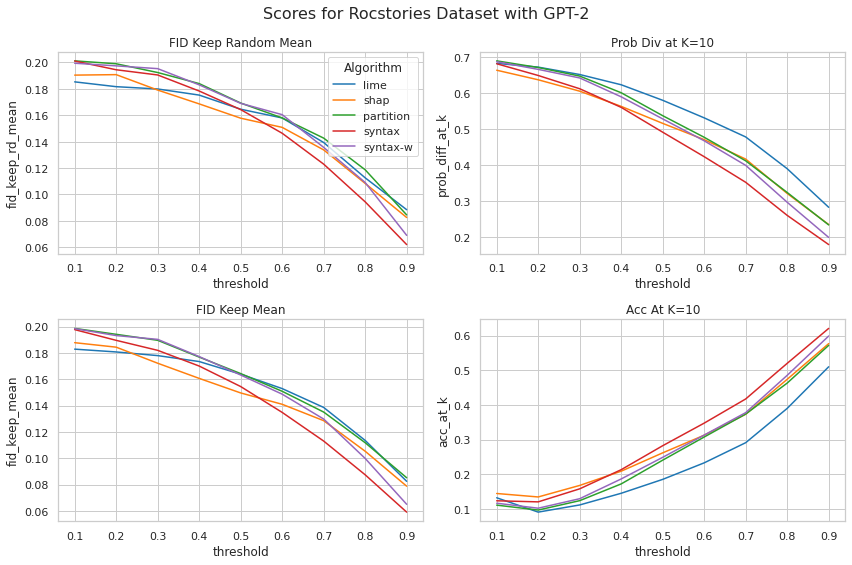

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = final_df[(final_df['dataset'] == 'rocstories')&(final_df['model'] == 'gpt2')]
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd_mean', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep_mean', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Rocstories Dataset with GPT-2', fontsize=16)

plt.tight_layout()
plt.show()


## Mistral LM

In [30]:
import os
import pandas as pd
import pickle
import numpy as np

folder_path = "/cluster/work/zhang/kamara/syntax-shap/results/scores/mistral"  # Replace with your folder path
bs = 64
# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')) and parts[1]!= "batch":
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[1]
            model_name = parts[2]
            algorithm = parts[3]
            seed = parts[4]
            threshold = parts[5].split('.pkl')[0]  # Removes the file extension

            # Construct the full file path
            file_path = os.path.join(folder_path, file)

            # Read the pickle file
            with open(full_path, 'rb') as file:
                data = pickle.load(file)

            n_min, n_max = 0, None
            #if dataset == 'generics':
                #n_max = 7 * bs
            #elif dataset == 'rocstories':
                #n_max = 8 * bs
            #else:
            


            # Assuming the content is a dictionary, create a DataFrame
            data['log_odds_keep_mean'] = np.mean(data['log_odds_keep'][n_min:n_max])
            data['fid_keep_rd_mean'] = np.mean(data['fid_keep_rd'][n_min:n_max])
            data['fid_keep_mean'] = np.mean(data['fid_keep'][n_min:n_max])
            data['fid_rmv_mean'] = np.mean(data['fid_rmv'][n_min:n_max])
            data['prob_diff_at_k'] = np.mean(data['prob_diff_at_k'][n_min:n_max])
            data['acc_at_k'] = np.mean(np.abs(data['acc_at_k'][n_min:n_max]))
            df = pd.DataFrame([data])

            # Add the extracted details as new columns
            df['dataset'] = dataset
            df['model'] = model_name
            df['algorithm'] = algorithm
            df['threshold'] = eval(threshold)

            # Append to the list of dataframes
            df_list.append(df)

# Concatenate all dataframes in the list
df = pd.concat(df_list, ignore_index=True)

col = ['dataset', 'model', 'algorithm', 'threshold', 'log_odds_keep_mean', 'fid_keep_mean', 'fid_rmv_mean', 'fid_keep_rd_mean', 'prob_diff_at_k', 'acc_at_k']
final_df = df[col]
final_df


,dataset,model,algorithm,threshold,log_odds_keep_mean,fid_keep_mean,fid_rmv_mean,fid_keep_rd_mean,prob_diff_at_k,acc_at_k
0,negation,mistral,partition,0.9,-3.770162,0.108644,0.203070,0.105536,0.326575,0.392169
1,negation,mistral,partition,0.8,-4.467771,0.131293,0.203581,0.130619,0.386043,0.336145
2,negation,mistral,partition,0.2,-8.285857,0.217173,0.062371,0.219368,0.723710,0.090663
3,negation,mistral,partition,0.6,-6.393146,0.177144,0.168518,0.184747,0.550128,0.221386
4,negation,mistral,partition,0.4,-7.447934,0.205670,0.137319,0.212540,0.649265,0.151807
...,...,...,...,...,...,...,...,...,...,...
129,generics,mistral,syntax,0.1,-10.055409,0.312198,0.071190,0.314607,0.776930,0.075641
130,generics,mistral,syntax,0.6,-5.365754,0.230209,0.299530,0.250214,0.551798,0.266667
131,generics,mistral,syntax,0.8,-3.497317,0.157709,0.310894,0.170367,0.378992,0.418298
132,generics,mistral,syntax,0.7,-4.592769,0.201241,0.306265,0.218419,0.483990,0.320746


/tmp/ipykernel_1157/764989192.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


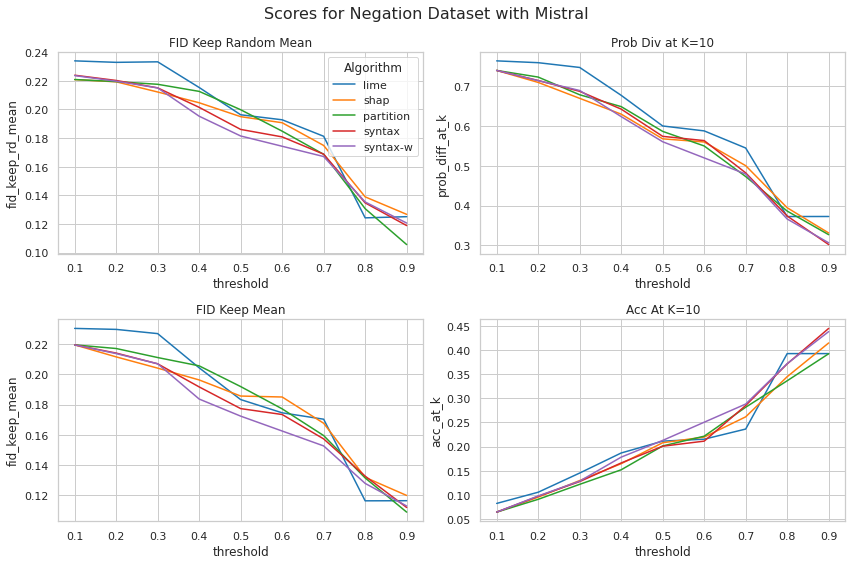

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = final_df[(final_df['dataset'] == 'negation')&(final_df['model'] == 'mistral')]
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd_mean', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep_mean', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Negation Dataset with Mistral', fontsize=16)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1157/1698845681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


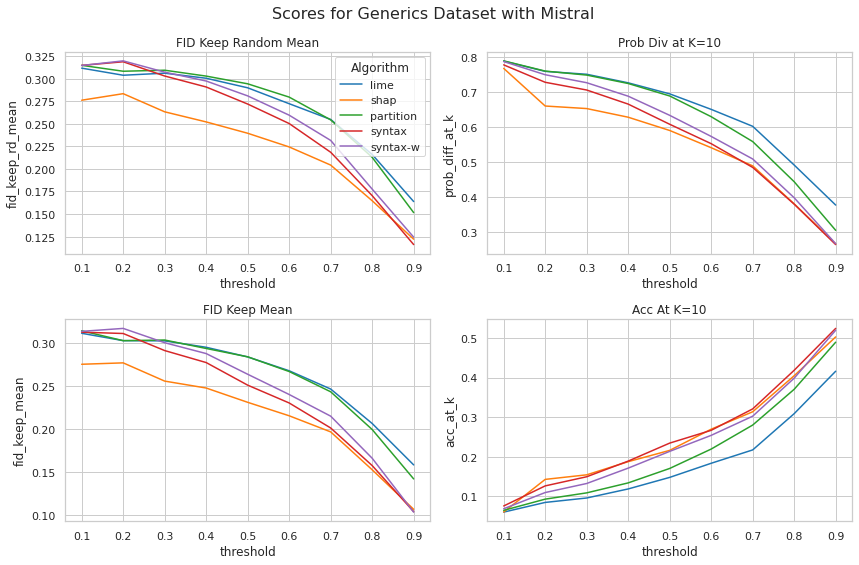

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = final_df[(final_df['dataset'] == 'generics')&(final_df['model'] == 'mistral')]
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd_mean', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep_mean', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Generics Dataset with Mistral', fontsize=16)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1157/3844063180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


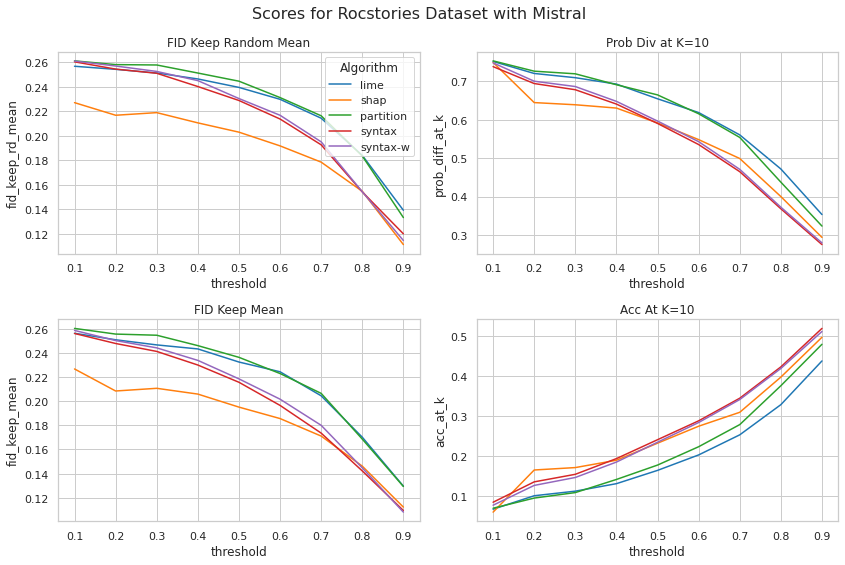

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = final_df[(final_df['dataset'] == 'rocstories')&(final_df['model'] == 'mistral')]
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd_mean', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep_mean', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Rocstories Dataset with Mistral', fontsize=16)

plt.tight_layout()
plt.show()


## GPT2 and Generics

In [1]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Sample examples with explanations, predictions and scores

In [12]:
data_save_dir = "/cluster/home/kamara/syntax-shap/data"
batch_size = 64

dataset = "generics"
model_name = "gpt2"
threshold_ = 0.2


filter_ids_path = os.path.join(data_save_dir, f"{dataset}")
with open(os.path.join(filter_ids_path, f"{dataset}_{model_name}_stats.pkl"), "rb") as f:
    stats = pickle.load(f)

print("Size of the dataset:", stats["n_data"])
print("Size of filtered dataset:", stats["n_filtered"])
print("Maximum number of batches:", stats["n_filtered"]//batch_size)

Size of the dataset: 5777
Size of filtered dataset: 1434
Maximum number of batches: 22


In [9]:
import csv
import sys

import numpy as np
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

MIN_TRANSFORMERS_VERSION = "4.25.1"

# check transformers version
assert (
    transformers.__version__ >= MIN_TRANSFORMERS_VERSION
), f"Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher."

root_dir = "/cluster/home/kamara/syntax-shap/shap2"
sys.path.append(root_dir)


from models import TextGeneration
import torch

model_name = "gpt2"#"mistralai/Mistral-7B-v0.1"
# model = GPT2LMHeadModel.from_pretrained("gpt2") #
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, is_fast=False)
tokenizer.pad_token = tokenizer.eos_token

# set model decoder to true
model.config.is_decoder = True
# set text-generation params under task_specific_params
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_new_tokens": 1,
    #"temperature": 0.7,
    #"top_k": 50,
    #"no_repeat_ngram_size": 2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lmmodel = TextGeneration(model, tokenizer, device=device)

/cluster/home/kamara/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [41]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/explanations/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-4]
            model_name = parts[-3]
            algorithm = parts[-2]
            seed = parts[-1].split('.pkl')[0]  # Removes the file extension
           
            # Construct the full file path
            file_path = os.path.join(folder_path, file)

            # Read the pickle file
            with open(full_path, 'rb') as file:
                data = pickle.load(file)

            # Assuming the content is a dictionary, create a DataFrame
            df = pd.DataFrame(data)
            # Add the extracted details as new columns
            df['algorithm'] = algorithm
            df['n_token'] = df['input'].str.split().apply(len)
            df['explanation'] = df['explanation'].apply(lambda x: x.reshape(-1))

            # Append to the list of dataframes
            df_list.append(df)

# Concatenate all dataframes in the list
df_explanation = pd.concat(df_list, ignore_index=True)
df_explanation


,input_id,input,explanation,algorithm,n_token
0,1441,Most books are published in English and,"[18337.0, 9203.0, -19953.0, -21503.0, 48442.0,...",partition,7
1,2587,Some families pass objects and ideas down from...,"[1072.0, -438.0, -5389.0, 5123.0, -1618.0, 102...",partition,10
2,3591,Some scientists drill ice cores to find out ab...,"[-9147.0, -12003.0, 10770.0, 20732.0, -9208.0,...",partition,12
3,378,Blocks are meant to be,"[1712.0, 24.0, 49929.0, 47509.0, -49475.0]",partition,5
4,2697,Ghost lights can be close to ground or in the,"[-7293.0, 11059.0, 5674.0, -700.0, 18186.0, -1...",partition,10
...,...,...,...,...,...
6717,2619,Light can go around the earth three times in one,"[0.10020294904085483, 0.10675048700362903, 0.0...",syntax,10
6718,2841,Capital goods are goods which are necessary fo...,"[0.05886052553455758, 0.0026913616576367118, 0...",syntax,10
6719,271,Thunder is made when lightning,"[0.12553044080713605, 0.024053866805230795, 0....",syntax,5
6720,505,More reactive acids are often more,"[0.18326838398870804, 0.12701752098068397, 0.1...",syntax,6


In [42]:
#### Select rows which input_ids are in the list of input_ids of the rows with algorithm = 'shap'

# Extract input_id values where algorithm is 'shap'
shap_input_ids = df_explanation[df_explanation['algorithm'] == 'shap']['input_id'].unique()

# Filter the DataFrame to keep rows where input_id is in shap_input_ids
filtered_df_explanation = df_explanation[df_explanation['input_id'].isin(shap_input_ids)]
filtered_df_explanation

,input_id,input,explanation,algorithm,n_token
0,1441,Most books are published in English and,"[18337.0, 9203.0, -19953.0, -21503.0, 48442.0,...",partition,7
1,2587,Some families pass objects and ideas down from...,"[1072.0, -438.0, -5389.0, 5123.0, -1618.0, 102...",partition,10
2,3591,Some scientists drill ice cores to find out ab...,"[-9147.0, -12003.0, 10770.0, 20732.0, -9208.0,...",partition,12
3,378,Blocks are meant to be,"[1712.0, 24.0, 49929.0, 47509.0, -49475.0]",partition,5
4,2697,Ghost lights can be close to ground or in the,"[-7293.0, 11059.0, 5674.0, -700.0, 18186.0, -1...",partition,10
...,...,...,...,...,...
6653,2577,Every round starts with both teams spawning at...,"[0.08207963213626256, 0.020277295555753725, 0....",syntax,10
6654,4296,Some people use mathematics to make visionary ...,"[0.04541181513746273, 0.03933105329327422, 0.0...",syntax,13
6655,3070,Ice hockey is one of the most popular sports i...,"[0.0010929091826351153, 0.0046906480595258464,...",syntax,11
6656,3465,People think it is one of the most beautiful u...,"[0.03492257711622961, 0.0337760339493351, 0.02...",syntax,11


In [44]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/scores/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-5]
            model_name = parts[-4]
            algorithm = parts[-3]
            seed = parts[-2]
            threshold = parts[-1].split('.pkl')[0]  # Removes the file extension

            if eval(threshold) == threshold_:
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['n_token'] = df['input'].str.split().apply(len)

                # Append to the list of dataframes
                df_list.append(df)

# Concatenate all dataframes in the list
df_final = pd.concat(df_list, ignore_index=True)
df_final


,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,input_id,input,algorithm,n_token
0,0.043038,0.043038,0.038864,-10.669853,0.1,0.639410,631,Different countries have different laws about,partition,6
1,0.020268,0.020268,-0.002350,-9.916850,0.1,0.544282,1755,Most people consider sweetness to be a pleasant,partition,8
2,0.027980,0.027980,0.019014,-10.239288,0.0,0.579648,3408,Salt is used to control the amount of water in...,partition,11
3,0.120370,0.172561,0.134914,-12.058515,0.1,0.711107,2263,Birth defects involving the brain are the most...,partition,9
4,0.080149,0.101141,0.115658,-2.075209,0.4,-0.001525,210,Many large cities have many,partition,5
...,...,...,...,...,...,...,...,...,...,...
6298,0.730913,0.730913,-0.005691,-13.502051,0.0,0.939271,2577,Every round starts with both teams spawning at...,syntax,10
6299,0.590625,0.590625,0.590625,-13.288939,0.1,0.924456,4296,Some people use mathematics to make visionary ...,syntax,13
6300,0.002519,0.002519,-0.008452,-7.831984,0.0,0.971329,3070,Ice hockey is one of the most popular sports i...,syntax,11
6301,0.808703,0.802731,0.082274,-3.466578,0.1,0.912648,3465,People think it is one of the most beautiful u...,syntax,11


In [45]:
sample = pd.merge(filtered_df_explanation, df_final, on=['input', 'input_id', 'algorithm', 'n_token'])

df_str = sample.groupby(['input_id', 'input']).mean().reset_index()[['input_id', 'input']]
df_str['y'] = df_str['input'].apply(lambda x: lmmodel.tokenizer.decode(lmmodel(x)[0]))

sample_with_y = pd.merge(sample, df_str, on=['input', 'input_id'])
#sample_with_y.to_csv(f"/cluster/home/kamara/syntax-shap/results/samples_{model_name}_{dataset}_{threshold_}.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [46]:
sample_with_y

,input_id,input,explanation,algorithm,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,y
0,1441,Most books are published in English and,"[18337.0, 9203.0, -19953.0, -21503.0, 48442.0,...",partition,7,0.228839,0.228839,-0.141421,-12.340778,0.1,0.605269,are
1,1441,Most books are published in English and,"[0.20712139965289372, 0.05568957414689275, 0.6...",syntax-w,7,0.060621,0.060621,0.028577,-11.012406,0.0,0.656117,are
2,1441,Most books are published in English and,"[-2.555568397853926e-05, -0.001326697190320633...",lime,7,0.060619,0.060619,0.027723,-11.012372,0.1,0.661523,are
3,1441,Most books are published in English and,"[0.08101423436152591, 0.09649190769968519, 0.1...",shap,7,0.228839,0.228839,0.000085,-12.340778,0.1,0.661523,are
4,1441,Most books are published in English and,"[0.27521228456398167, 0.04933163176458051, 0.5...",syntax,7,0.060621,0.060621,0.028577,-11.012406,0.0,0.656117,are
...,...,...,...,...,...,...,...,...,...,...,...,...
4638,3162,Some printing presses use lead type because it...,"[-31323.0, 29087.0, 18282.0, 14350.0, -13649.0...",partition,11,0.010868,0.010868,0.010868,-9.293669,0.1,0.451163,removed
4639,3162,Some printing presses use lead type because it...,"[0.09103024544510835, 0.13947750838638792, 0.0...",syntax-w,11,0.017348,0.017348,0.017348,-9.761263,0.0,0.480072,removed
4640,3162,Some printing presses use lead type because it...,"[3.341462080193861e-06, -1.509491264675188e-06...",lime,11,0.027245,0.027245,0.005211,-10.212659,0.0,0.497877,removed
4641,3162,Some printing presses use lead type because it...,"[0.08953232322725961, 0.08469806916944801, 0.0...",shap,11,0.007887,-0.007478,0.007887,0.666764,0.1,0.365457,removed


In [47]:
sample_with_y.to_csv(f"/cluster/home/kamara/syntax-shap/results/samples_{model_name}_{dataset}_{threshold_}.csv", index=False)

### N_tokens vs performance

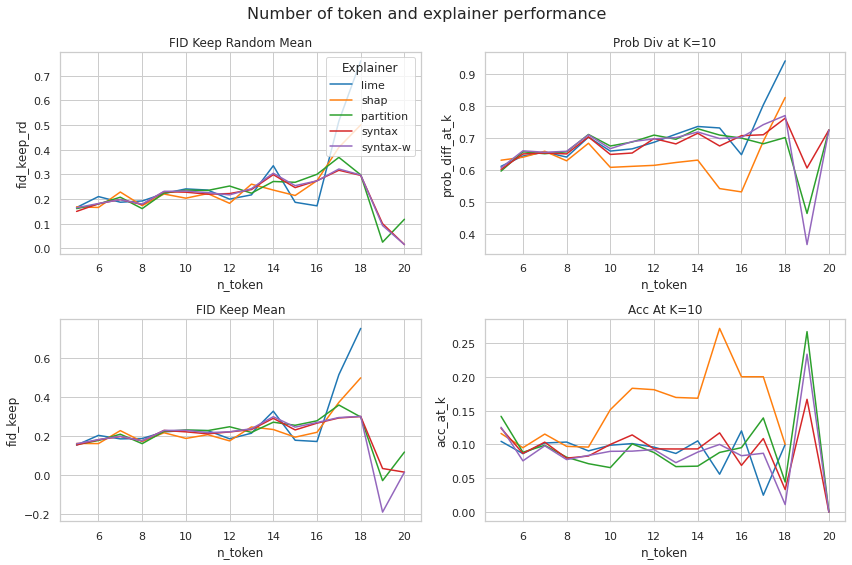

In [48]:
df = df_final.groupby(['algorithm', 'n_token']).mean().reset_index()

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='n_token', y='fid_keep_rd', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='n_token', y='fid_keep', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='n_token', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='n_token', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Explainer', loc='upper right')

fig.suptitle('Number of token and explainer performance', fontsize=16)

plt.tight_layout()
plt.show()

### Performance at Thresholds

In [49]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/scores/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-5]
            model_name = parts[-4]
            algorithm = parts[-3]
            seed = parts[-2]
            threshold = parts[-1].split('.pkl')[0]  # Removes the file extension

            # Construct the full file path
            file_path = os.path.join(folder_path, file)

            # Read the pickle file
            with open(full_path, 'rb') as file:
                data = pickle.load(file)

            # Assuming the content is a dictionary, create a DataFrame
            df = pd.DataFrame(data)

            # Add the extracted details as new columns
            df['algorithm'] = algorithm
            df['n_token'] = df['input'].str.split().apply(len)
            df['threshold'] = eval(threshold)

            # Append to the list of dataframes
            df_list.append(df)

# Concatenate all dataframes in the list
df_final = pd.concat(df_list, ignore_index=True)
df_final


,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,input_id,input,algorithm,n_token,threshold
0,0.043038,0.043038,0.038864,-10.669853,0.1,0.639410,631,Different countries have different laws about,partition,6,0.2
1,0.020268,0.020268,-0.002350,-9.916850,0.1,0.544282,1755,Most people consider sweetness to be a pleasant,partition,8,0.2
2,0.027980,0.027980,0.019014,-10.239288,0.0,0.579648,3408,Salt is used to control the amount of water in...,partition,11,0.2
3,0.120370,0.172561,0.134914,-12.058515,0.1,0.711107,2263,Birth defects involving the brain are the most...,partition,9,0.2
4,0.080149,0.101141,0.115658,-2.075209,0.4,-0.001525,210,Many large cities have many,partition,5,0.2
...,...,...,...,...,...,...,...,...,...,...,...
51126,0.009948,0.064716,0.112720,-0.853615,0.3,0.417359,1299,Many people use it as a,syntax,6,0.6
51127,0.017747,-0.068190,0.024610,1.327267,0.3,0.222690,5535,People do the tea ceremony in a special tea ro...,syntax,16,0.6
51128,0.013101,-0.003115,0.013101,0.213280,0.4,0.484355,2775,Many countries have laws that require the use ...,syntax,10,0.6
51129,-0.056811,-0.018653,0.304609,0.054875,0.3,0.217669,158,Many passes are closed in,syntax,5,0.6


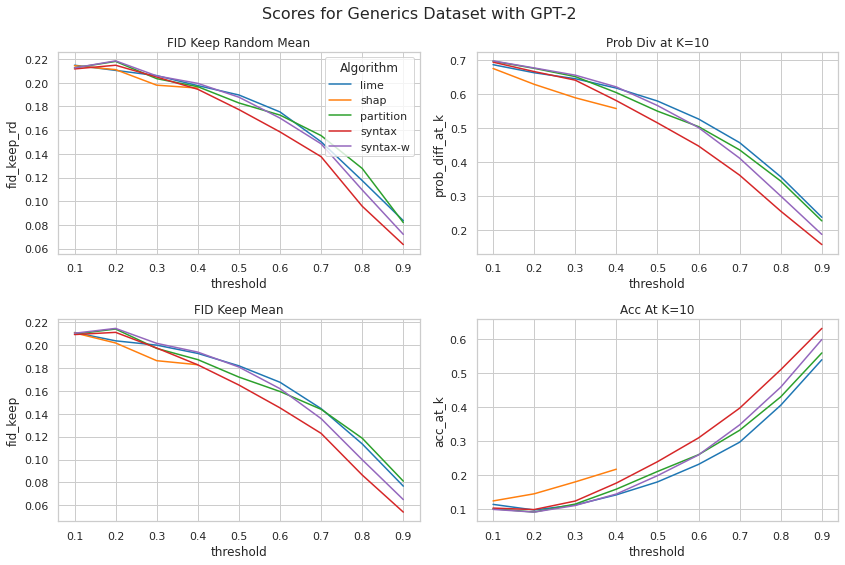

In [50]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = df_final.groupby(['algorithm', 'threshold']).mean().reset_index()
# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

# Plotting with Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Creating a lineplot for each score
sns.lineplot(x='threshold', y='fid_keep_rd', hue='algorithm', data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('FID Keep Random Mean')

sns.lineplot(x='threshold', y='fid_keep', hue='algorithm', data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('FID Keep Mean')

sns.lineplot(x='threshold', y='prob_diff_at_k', hue='algorithm', data=df, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('Prob Div at K=10')

sns.lineplot(x='threshold', y='acc_at_k', hue='algorithm', data=df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Acc At K=10')

# Remove legends from all but one plot
for ax in axes.flat:
    ax.legend().remove()

# Add the legend back to the first subplot
axes[0, 0].legend(title='Algorithm', loc='upper right')

fig.suptitle('Scores for Generics Dataset with GPT-2', fontsize=16)

plt.tight_layout()
plt.show()
